## BERT on SQUAD Dataset
---------------
* Most of the code is taken referance from google-research 
* The bert model is **fine-tuned** only.
* Code has been modified as per necesscity
* Used the **bert uncased_L-12_H-768_A-12** model
* All the referance are mentioned in the referances section

In [6]:
# importing all necessary files

import zipfile
from matplotlib import pyplot as plt
%matplotlib inline
import sys
import datetime
import tensorflow as tf
import os
import json
import six

from collections import Counter
import string
import re
import argparse
import sys

## Configuring TPU

This section, you perform the following tasks:
  * Set up a Colab TPU running environment
  * Verify that you are connected to a TPU device

Once done. Upload your credentials to TPU to access your GCS bucket.

In [0]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.12.236.42:8470


W0827 05:51:10.907844 140491252946816 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 11440417705514041917),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11361402579519159698),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12357697597335777241),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 7898279176896720777),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 16769548510779700091),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 9684062799403801468),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 18088205161317314166),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 2719725766142665814),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 12910852574047901557),
 _DeviceAttributes(/job:tpu_

**import necessary BERT modules**

In [0]:
import sys

!test -d bert_repo || git clone https://github.com/google-research/bert bert_repo
if not 'bert_repo' in sys.path:
  sys.path += ['bert_repo']

# import python modules defined by BERT
import run_squad
import modeling
import optimization
import tokenization
import tensorflow as tf
import tokenization

# import tfhub 
import tensorflow_hub as hub

Cloning into 'bert_repo'...
remote: Enumerating objects: 333, done.
remote: Total 333 (delta 0), reused 0 (delta 0), pack-reused 333
Receiving objects: 100% (333/333), 282.46 KiB | 3.98 MiB/s, done.
Resolving deltas: 100% (183/183), done.


W0827 06:05:06.749072 140491252946816 deprecation_wrapper.py:119] From bert_repo/optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



**This next section of code performs the following tasks:**

*  Specify BERT pretrained model [uncased_L-12_H-768_A-12]
*  Create output directory for model checkpoints and eval results.


In [0]:
TASK = 'SQUAD' #@param {type:"string"}
assert TASK in ('MRPC', 'CoLA',"SQUAD"), 'Only (MRPC, CoLA) are demonstrated here.'


BUCKET = 'bert-on-squad' #@param {type:"string"}
assert BUCKET, 'Must specify an existing GCS bucket name'
OUTPUT_DIR = 'gs://{}/bert-tfhub/models/{}'.format(BUCKET, TASK)
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

# Available pretrained model checkpoints:
#   uncased_L-12_H-768_A-12: uncased BERT base model
#   uncased_L-24_H-1024_A-16: uncased BERT large model
#   cased_L-12_H-768_A-12: cased BERT large model
BERT_MODEL = 'uncased_L-12_H-768_A-12' #@param {type:"string"}
BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_' + BERT_MODEL + '/1'

***** Model output directory: gs://bert-on-squad/bert-tfhub/models/SQUAD *****


In [0]:
# Setup TPU related config
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
NUM_TPU_CORES = 8
ITERATIONS_PER_LOOP = 1000

In [0]:
# Setup task specific model and TPU running config.
BERT_PRETRAINED_DIR = 'gs://cloud-tpu-checkpoints/bert/' + BERT_MODEL 
print('***** BERT pretrained directory: {} *****'.format(BERT_PRETRAINED_DIR))
!gsutil ls $BERT_PRETRAINED_DIR


***** BERT pretrained directory: gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12 *****
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_config.json
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt.index
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/bert_model.ckpt.meta
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/checkpoint
gs://cloud-tpu-checkpoints/bert/uncased_L-12_H-768_A-12/vocab.txt


In [0]:
# seting up necessary path files for models
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
DO_LOWER_CASE = BERT_MODEL.startswith('uncased')

In [0]:
OUTPUT_DIR = OUTPUT_DIR.replace('bert-tfhub', 'bert-checkpoints')
tf.gfile.MakeDirs(OUTPUT_DIR)

## Get SQUAD Dataset

In [0]:
with zipfile.ZipFile("/content/train-v1.1.json.zip","r") as zip_ref:
    zip_ref.extractall()
    
with zipfile.ZipFile("/content/dev-v1.1.json.zip","r") as zip_ref:
    zip_ref.extractall()

### Important Functions:

**read_squad_examples :**
This function takes input as **json** file and retunrs the object of SquadExample claas. Which is nothing but, container storinng our each data point.

In [0]:
def read_squad_examples(input_file, is_training):
  """Read a SQuAD json file into a list of SquadExample."""
  with tf.gfile.Open(input_file, "r") as reader:
    input_data = json.load(reader)["data"]

  def is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
      return True
    return False

  examples = []
  for entry in input_data:
    for paragraph in entry["paragraphs"]:
      paragraph_text = paragraph["context"]
      doc_tokens = []
      char_to_word_offset = []
      prev_is_whitespace = True
      for c in paragraph_text:
        if is_whitespace(c):
          prev_is_whitespace = True
        else:
          if prev_is_whitespace:
            doc_tokens.append(c)
          else:
            doc_tokens[-1] += c
          prev_is_whitespace = False
        char_to_word_offset.append(len(doc_tokens) - 1)

      for qa in paragraph["qas"]:
        qas_id = qa["id"]
        question_text = qa["question"]
        start_position = None
        end_position = None
        orig_answer_text = None
        is_impossible = False
        if is_training:

          if False:
            is_impossible = qa["is_impossible"]
          if (len(qa["answers"]) != 1) and (not is_impossible):
            raise ValueError(
                "For training, each question should have exactly 1 answer.")
          if not is_impossible:
            answer = qa["answers"][0]
            orig_answer_text = answer["text"]
            answer_offset = answer["answer_start"]
            answer_length = len(orig_answer_text)
            start_position = char_to_word_offset[answer_offset]
            end_position = char_to_word_offset[answer_offset + answer_length -
                                               1]
            # Only add answers where the text can be exactly recovered from the
            # document. If this CAN'T happen it's likely due to weird Unicode
            # stuff so we will just skip the example.
            #
            # Note that this means for training mode, every example is NOT
            # guaranteed to be preserved.
            actual_text = " ".join(
                doc_tokens[start_position:(end_position + 1)])
            cleaned_answer_text = " ".join(
                tokenization.whitespace_tokenize(orig_answer_text))
            if actual_text.find(cleaned_answer_text) == -1:
              tf.logging.warning("Could not find answer: '%s' vs. '%s'",
                                 actual_text, cleaned_answer_text)
              continue
          else:
            start_position = -1
            end_position = -1
            orig_answer_text = ""

        example = run_squad.SquadExample(
            qas_id=qas_id,
            question_text=question_text,
            doc_tokens=doc_tokens,
            orig_answer_text=orig_answer_text,
            start_position=start_position,
            end_position=end_position,
            is_impossible=is_impossible)
        examples.append(example)

  return examples

In [0]:
train_examples = read_squad_examples("/content/train-v1.1.json",True)
print("Total train examples are ",len(train_examples))


Total train examples are  87599


In [0]:
print("Type of return :\n",type(train_examples[0]))
print("*"*60)
print("Question ID : ",train_examples[0].qas_id)
print("*"*60)
print("question_text : ",train_examples[0].question_text)
print("*"*60)
print("doc_tokens : ",train_examples[0].doc_tokens)
print("*"*60)
print("start_position : ",train_examples[0].start_position)
print("end_position : ",train_examples[0].end_position)
print("*"*60)
print("is_impossible : ",train_examples[0].is_impossible)


Type of return :
 <class 'run_squad.SquadExample'>
************************************************************
Question ID :  5733be284776f41900661182
************************************************************
question_text :  To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
************************************************************
doc_tokens :  ['Architecturally,', 'the', 'school', 'has', 'a', 'Catholic', 'character.', 'Atop', 'the', 'Main', "Building's", 'gold', 'dome', 'is', 'a', 'golden', 'statue', 'of', 'the', 'Virgin', 'Mary.', 'Immediately', 'in', 'front', 'of', 'the', 'Main', 'Building', 'and', 'facing', 'it,', 'is', 'a', 'copper', 'statue', 'of', 'Christ', 'with', 'arms', 'upraised', 'with', 'the', 'legend', '"Venite', 'Ad', 'Me', 'Omnes".', 'Next', 'to', 'the', 'Main', 'Building', 'is', 'the', 'Basilica', 'of', 'the', 'Sacred', 'Heart.', 'Immediately', 'behind', 'the', 'basilica', 'is', 'the', 'Grotto,', 'a', 'Marian', 'place', 'of', 'prayer', 'an

**Write Predicitons :**

This funciton is used to write predictions to output file provided. It internally uses get_final_text.

In [0]:
def get_final_text(pred_text, orig_text, do_lower_case):
  """Project the tokenized prediction back to the original text."""

  def _strip_spaces(text):
    ns_chars = []
    ns_to_s_map = collections.OrderedDict()
    for (i, c) in enumerate(text):
      if c == " ":
        continue
      ns_to_s_map[len(ns_chars)] = i
      ns_chars.append(c)
    ns_text = "".join(ns_chars)
    return (ns_text, ns_to_s_map)

  # We first tokenize `orig_text`, strip whitespace from the result
  # and `pred_text`, and check if they are the same length. If they are
  # NOT the same length, the heuristic has failed. If they are the same
  # length, we assume the characters are one-to-one aligned.
  tokenizer = tokenization.BasicTokenizer(do_lower_case=do_lower_case)

  tok_text = " ".join(tokenizer.tokenize(orig_text))

  start_position = tok_text.find(pred_text)
  if start_position == -1:
    if True:
      tf.logging.info(
          "Unable to find text: '%s' in '%s'" % (pred_text, orig_text))
    return orig_text
  end_position = start_position + len(pred_text) - 1

  (orig_ns_text, orig_ns_to_s_map) = _strip_spaces(orig_text)
  (tok_ns_text, tok_ns_to_s_map) = _strip_spaces(tok_text)

  if len(orig_ns_text) != len(tok_ns_text):
    if True:
      tf.logging.info("Length not equal after stripping spaces: '%s' vs '%s'",
                      orig_ns_text, tok_ns_text)
    return orig_text

  # We then project the characters in `pred_text` back to `orig_text` using
  # the character-to-character alignment.
  tok_s_to_ns_map = {}
  for (i, tok_index) in six.iteritems(tok_ns_to_s_map):
    tok_s_to_ns_map[tok_index] = i

  orig_start_position = None
  if start_position in tok_s_to_ns_map:
    ns_start_position = tok_s_to_ns_map[start_position]
    if ns_start_position in orig_ns_to_s_map:
      orig_start_position = orig_ns_to_s_map[ns_start_position]

  if orig_start_position is None:
    if True:
      tf.logging.info("Couldn't map start position")
    return orig_text

  orig_end_position = None
  if end_position in tok_s_to_ns_map:
    ns_end_position = tok_s_to_ns_map[end_position]
    if ns_end_position in orig_ns_to_s_map:
      orig_end_position = orig_ns_to_s_map[ns_end_position]

  if orig_end_position is None:
    if True:
      tf.logging.info("Couldn't map end position")
    return orig_text

  output_text = orig_text[orig_start_position:(orig_end_position + 1)]
  return output_text

In [0]:
def write_predictions(all_examples, all_features, all_results, n_best_size,
                      max_answer_length, do_lower_case, output_prediction_file,
                      output_nbest_file, output_null_log_odds_file):
  """Write final predictions to the json file and log-odds of null if needed."""
  
  tf.logging.info("Writing predictions to: %s" % (output_prediction_file))
  tf.logging.info("Writing nbest to: %s" % (output_nbest_file))

  example_index_to_features = collections.defaultdict(list)
  for feature in all_features:
    example_index_to_features[feature.example_index].append(feature)

  unique_id_to_result = {}
  for result in all_results:
    unique_id_to_result[result.unique_id] = result

  _PrelimPrediction = collections.namedtuple(  # pylint: disable=invalid-name
      "PrelimPrediction",
      ["feature_index", "start_index", "end_index", "start_logit", "end_logit"])

  all_predictions = collections.OrderedDict()
  all_nbest_json = collections.OrderedDict()
  scores_diff_json = collections.OrderedDict()

  for (example_index, example) in enumerate(all_examples):
    features = example_index_to_features[example_index]

    prelim_predictions = []
    # keep track of the minimum score of null start+end of position 0
    score_null = 1000000  # large and positive
    min_null_feature_index = 0  # the paragraph slice with min mull score
    null_start_logit = 0  # the start logit at the slice with min null score
    null_end_logit = 0  # the end logit at the slice with min null score
    for (feature_index, feature) in enumerate(features):
      result = unique_id_to_result[feature.unique_id]
      start_indexes = run_squad._get_best_indexes(result.start_logits, n_best_size)
      end_indexes = run_squad._get_best_indexes(result.end_logits, n_best_size)
      # if we could have irrelevant answers, get the min score of irrelevant
      if False:
        feature_null_score = result.start_logits[0] + result.end_logits[0]
        if feature_null_score < score_null:
          score_null = feature_null_score
          min_null_feature_index = feature_index
          null_start_logit = result.start_logits[0]
          null_end_logit = result.end_logits[0]
      for start_index in start_indexes:
        for end_index in end_indexes:
          # We could hypothetically create invalid predictions, e.g., predict
          # that the start of the span is in the question. We throw out all
          # invalid predictions.
          if start_index >= len(feature.tokens):
            continue
          if end_index >= len(feature.tokens):
            continue
          if start_index not in feature.token_to_orig_map:
            continue
          if end_index not in feature.token_to_orig_map:
            continue
          if not feature.token_is_max_context.get(start_index, False):
            continue
          if end_index < start_index:
            continue
          length = end_index - start_index + 1
          if length > max_answer_length:
            continue
          prelim_predictions.append(
              _PrelimPrediction(
                  feature_index=feature_index,
                  start_index=start_index,
                  end_index=end_index,
                  start_logit=result.start_logits[start_index],
                  end_logit=result.end_logits[end_index]))

    if False:
      prelim_predictions.append(
          _PrelimPrediction(
              feature_index=min_null_feature_index,
              start_index=0,
              end_index=0,
              start_logit=null_start_logit,
              end_logit=null_end_logit))
    prelim_predictions = sorted(
        prelim_predictions,
        key=lambda x: (x.start_logit + x.end_logit),
        reverse=True)

    _NbestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
        "NbestPrediction", ["text", "start_logit", "end_logit"])

    seen_predictions = {}
    nbest = []
    for pred in prelim_predictions:
      if len(nbest) >= n_best_size:
        break
      feature = features[pred.feature_index]
      if pred.start_index > 0:  # this is a non-null prediction
        tok_tokens = feature.tokens[pred.start_index:(pred.end_index + 1)]
        orig_doc_start = feature.token_to_orig_map[pred.start_index]
        orig_doc_end = feature.token_to_orig_map[pred.end_index]
        orig_tokens = example.doc_tokens[orig_doc_start:(orig_doc_end + 1)]
        tok_text = " ".join(tok_tokens)

        # De-tokenize WordPieces that have been split off.
        tok_text = tok_text.replace(" ##", "")
        tok_text = tok_text.replace("##", "")

        # Clean whitespace
        tok_text = tok_text.strip()
        tok_text = " ".join(tok_text.split())
        orig_text = " ".join(orig_tokens)

        final_text = get_final_text(tok_text, orig_text, do_lower_case)
        if final_text in seen_predictions:
          continue

        seen_predictions[final_text] = True
      else:
        final_text = ""
        seen_predictions[final_text] = True

      nbest.append(
          _NbestPrediction(
              text=final_text,
              start_logit=pred.start_logit,
              end_logit=pred.end_logit))

    # if we didn't inlude the empty option in the n-best, inlcude it
    if False:
      if "" not in seen_predictions:
        nbest.append(
            _NbestPrediction(
                text="", start_logit=null_start_logit,
                end_logit=null_end_logit))
    # In very rare edge cases we could have no valid predictions. So we
    # just create a nonce prediction in this case to avoid failure.
    if not nbest:
      nbest.append(
          _NbestPrediction(text="empty", start_logit=0.0, end_logit=0.0))

    assert len(nbest) >= 1

    total_scores = []
    best_non_null_entry = None
    for entry in nbest:
      total_scores.append(entry.start_logit + entry.end_logit)
      if not best_non_null_entry:
        if entry.text:
          best_non_null_entry = entry

    probs = run_squad._compute_softmax(total_scores)

    nbest_json = []
    for (i, entry) in enumerate(nbest):
      output = collections.OrderedDict()
      output["text"] = entry.text
      output["probability"] = probs[i]
      output["start_logit"] = entry.start_logit
      output["end_logit"] = entry.end_logit
      nbest_json.append(output)

    assert len(nbest_json) >= 1

    if not False:
      all_predictions[example.qas_id] = nbest_json[0]["text"]
    else:
      # predict "" iff the null score - the score of best non-null > threshold
      score_diff = score_null - best_non_null_entry.start_logit - (
          best_non_null_entry.end_logit)
      scores_diff_json[example.qas_id] = score_diff
      if score_diff > 0.0:
        all_predictions[example.qas_id] = ""
      else:
        all_predictions[example.qas_id] = best_non_null_entry.text

    all_nbest_json[example.qas_id] = nbest_json

  with tf.gfile.GFile(output_prediction_file, "w") as writer:
    writer.write(json.dumps(all_predictions, indent=4) + "\n")

  with tf.gfile.GFile(output_nbest_file, "w") as writer:
    writer.write(json.dumps(all_nbest_json, indent=4) + "\n")

  if False:
    with tf.gfile.GFile(output_null_log_odds_file, "w") as writer:
      writer.write(json.dumps(scores_diff_json, indent=4) + "\n")

**Model Parameters**

In [0]:
# Model Hyper Parameters
TRAIN_BATCH_SIZE = 16
LEARNING_RATE = 3e-5
NUM_TRAIN_EPOCHS = 2.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 256
EVAL_BATCH_SIZE = 8

tpu_cluster_resolver = None
SAVE_CHECKPOINTS_STEPS = 1000
ITERATIONS_PER_LOOP = 1000
NUM_TPU_CORES = 8


**Tokenizer**:

Takes vocab file as input.

In [10]:
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=True)

**Tokenization examples**

In [9]:
tokenizer.tokenize("This is a different and longer example to check the 'Tokenization'.")

['this',
 'is',
 'a',
 'different',
 'and',
 'longer',
 'example',
 'to',
 'check',
 'the',
 "'",
 'token',
 '##ization',
 "'",
 '.']

In [0]:
tokenizer.tokenize("this is demo example for tokenizer")

['this', 'is', 'demo', 'example', 'for', 'token', '##izer']

In [0]:
num_train_steps = int(
    len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)


In [0]:
# Setup TPU related config
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
NUM_TPU_CORES = 8

**model function builds model**

In [0]:
model_fn = run_squad.model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=True, #If False training will fall on CPU or GPU, depending on what is available  
    use_one_hot_embeddings=True)

In [0]:
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))


In [0]:
estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=True, #If False training will fall on CPU or GPU, depending on what is available 
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    predict_batch_size=EVAL_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE)


W0827 06:18:43.056533 140491252946816 estimator.py:1984] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7fc65e7fe950>) includes params argument, but params are not passed to Estimator.


In [0]:
print('Please wait...')
train_writer = run_squad.FeatureWriter(
        filename=os.path.join(OUTPUT_DIR, "train.tf_record"),
        is_training=True)


def append_feature(feature):
  train_features.append(feature)
  train_writer.process_feature(feature)


W0827 06:18:46.242335 140491252946816 deprecation_wrapper.py:119] From bert_repo/run_squad.py:1065: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.



Please wait...


### convert_examples_to_features

This function converts train examples got from read_squad_examples to features that can be fed to BERT model. It returns all features in InputFeatures class object.

**Input Feature class schema:**

    unique_id,<br>
    example_index,<br>
    doc_span_index,<br>
    tokens,<br>
    token_to_orig_map,<br>
    token_is_max_context,<br>
    input_ids,<br>
    input_mask,<br>
    segment_ids,<br>
    start_position=None,<br>
    end_position=None,<br>
    is_impossible=None<br>
    

In [0]:
train_features = []

run_squad.convert_examples_to_features(train_examples, tokenizer, MAX_SEQ_LENGTH, 128, 64, True, output_fn=append_feature)

train_writer.close()


W0827 06:18:47.903628 140491252946816 deprecation_wrapper.py:119] From bert_repo/run_squad.py:431: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



In [67]:
print("example to feature :")
print(type(train_features[0]))
print("-"*70)
print("unique_id : ",train_features[0].unique_id)
print("-"*70)
print("example_index :",train_features[0].example_index)
print("-"*70)
print("doc_span_index :",train_features[0].doc_span_index)
print("-"*70)
print("tokens :")
print(train_features[0].tokens)
print("-"*70)
print("token_to_orig_map :")
print(train_features[0].token_to_orig_map)
print("-"*70)
print("token_is_max_context :")
print(train_features[0].token_is_max_context)
print("-"*70)
print("input_ids :")
print(train_features[0].input_ids)
print("-"*70)
print("segment_ids :")
print(train_features[0].segment_ids)
print("-"*70)
print("start_position : ",train_features[0].start_position)
print("-"*70)
print("end_position :",train_features[0].end_position)
print("-"*70)
print("is_impossible :",train_features[0].is_impossible)


example to feature :
<class 'run_squad.InputFeatures'>
----------------------------------------------------------------------
unique_id :  1000000000
----------------------------------------------------------------------
example_index : 0
----------------------------------------------------------------------
doc_span_index : 0
----------------------------------------------------------------------
tokens :
['[CLS]', 'to', 'whom', 'did', 'the', 'virgin', 'mary', 'allegedly', 'appear', 'in', '1858', 'in', 'lou', '##rdes', 'france', '?', '[SEP]', 'architectural', '##ly', ',', 'the', 'school', 'has', 'a', 'catholic', 'character', '.', 'atop', 'the', 'main', 'building', "'", 's', 'gold', 'dome', 'is', 'a', 'golden', 'statue', 'of', 'the', 'virgin', 'mary', '.', 'immediately', 'in', 'front', 'of', 'the', 'main', 'building', 'and', 'facing', 'it', ',', 'is', 'a', 'copper', 'statue', 'of', 'christ', 'with', 'arms', 'up', '##rai', '##sed', 'with', 'the', 'legend', '"', 've', '##ni', '##te', 'ad'

In [0]:
print(len(train_examples))
print(len(train_features))

87599
97077


In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

### Loss Function :

* It uses **categotical crossentropy** loss function internally.
* Calcaulates loss seperately for start_token and end_token
* total loss is average of start and end loss


In [0]:
print('***** Started training at {} *****'.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))


tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = run_squad.input_fn_builder(
    input_file=train_writer.filename,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)

estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('***** Finished training at {} *****'.format(datetime.datetime.now()))


I0827 06:24:27.257017 140491252946816 <ipython-input-41-9544e7b43547>:6]   Num steps = 10949
W0827 06:24:27.258475 140491252946816 deprecation_wrapper.py:119] From bert_repo/run_squad.py:691: The name tf.FixedLenFeature is deprecated. Please use tf.io.FixedLenFeature instead.



***** Started training at 2019-08-27 06:24:27.255979 *****
  Num examples = 87599
  Batch size = 16


I0827 06:24:28.046493 140491252946816 estimator.py:360] Skipping training since max_steps has already saved.
I0827 06:24:28.047625 140491252946816 error_handling.py:96] training_loop marked as finished


***** Finished training at 2019-08-27 06:24:28.050430 *****


## Prediction

The below steps are used while prediciton:

* A Dense layer followed by softmax layer is applied on the final output. 
* The probability of word i being the start of the answer span is computed as a dot product between Ti and S followed by a softmax over all of the words in the paragraph.
* The end and start tokens are chosen which maximises probabilities.

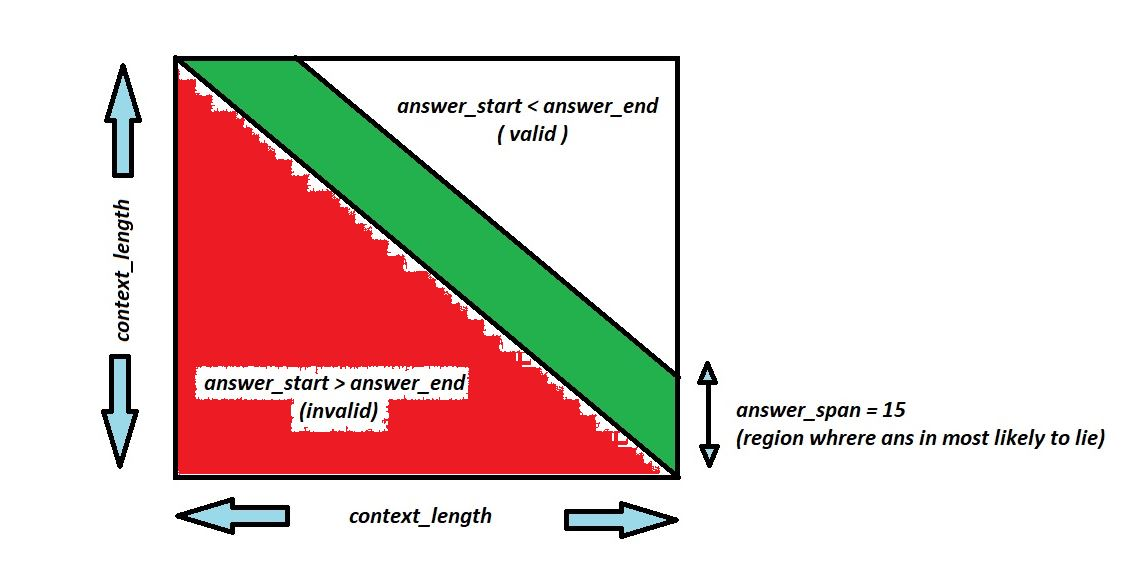

In [0]:
eval_examples = read_squad_examples("/content/dev-v1.1.json",False)

In [57]:
print("type of eval ",type(eval_examples))
print("-"*60)
print(eval_examples[0].qas_id)
print("-"*60)
print(eval_examples[0].doc_tokens)

type of eval  <class 'list'>
------------------------------------------------------------
56be4db0acb8001400a502ec
------------------------------------------------------------
['Super', 'Bowl', '50', 'was', 'an', 'American', 'football', 'game', 'to', 'determine', 'the', 'champion', 'of', 'the', 'National', 'Football', 'League', '(NFL)', 'for', 'the', '2015', 'season.', 'The', 'American', 'Football', 'Conference', '(AFC)', 'champion', 'Denver', 'Broncos', 'defeated', 'the', 'National', 'Football', 'Conference', '(NFC)', 'champion', 'Carolina', 'Panthers', '24–10', 'to', 'earn', 'their', 'third', 'Super', 'Bowl', 'title.', 'The', 'game', 'was', 'played', 'on', 'February', '7,', '2016,', 'at', "Levi's", 'Stadium', 'in', 'the', 'San', 'Francisco', 'Bay', 'Area', 'at', 'Santa', 'Clara,', 'California.', 'As', 'this', 'was', 'the', '50th', 'Super', 'Bowl,', 'the', 'league', 'emphasized', 'the', '"golden', 'anniversary"', 'with', 'various', 'gold-themed', 'initiatives,', 'as', 'well', 'as', 't

In [0]:
eval_writer = run_squad.FeatureWriter(
    filename=os.path.join(OUTPUT_DIR, "eval.tf_record"),
    is_training=False)

In [0]:

def append_feature(feature):
    eval_features.append(feature)
    eval_writer.process_feature(feature)


In [2]:
eval_features = []

run_squad.convert_examples_to_features(
        examples=eval_examples,
        tokenizer=tokenizer,
        max_seq_length=MAX_SEQ_LENGTH,
        doc_stride=128,
        max_query_length=64,
        is_training=False,
        output_fn=append_feature)

eval_writer.close()

In [0]:
print(len(eval_examples))
print(len(eval_features))

10570
12006


In [0]:
tf.logging.info("***** Running predictions *****")
tf.logging.info("  Num orig examples = %d", len(eval_examples))
tf.logging.info("  Num features = %d", len(eval_features))

predict_input_fn = run_squad.input_fn_builder(
    input_file=eval_writer.filename,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

I0827 06:25:10.172574 140491252946816 <ipython-input-47-84a684c96aaa>:1] ***** Running predictions *****
I0827 06:25:10.174535 140491252946816 <ipython-input-47-84a684c96aaa>:2]   Num orig examples = 10570
I0827 06:25:10.175938 140491252946816 <ipython-input-47-84a684c96aaa>:3]   Num features = 12006


In [1]:
all_results = []
for result in estimator.predict(predict_input_fn, yield_single_examples=True):
    if len(all_results) % 1000 == 0:
        tf.logging.info("Processing example: %d" % (len(all_results)))
    unique_id = int(result["unique_ids"])
    start_logits = [float(x) for x in result["start_logits"].flat]
    end_logits = [float(x) for x in result["end_logits"].flat]
    all_results.append(
          run_squad.RawResult(
              unique_id=unique_id,
              start_logits=start_logits,
              end_logits=end_logits))


In [0]:
output_prediction_file = os.path.join(OUTPUT_DIR, "predictions.json")
output_nbest_file = os.path.join(OUTPUT_DIR, "nbest_predictions.json")
output_null_log_odds_file = os.path.join(OUTPUT_DIR, "null_odds.json")


In [0]:
import collections
import json

write_predictions(eval_examples, eval_features, all_results,
                      20, 30,
                      True, output_prediction_file,
                      output_nbest_file, output_null_log_odds_file)


### F1 Score Calcualtion

In [0]:
# please refer https://github.com/allenai/bi-att-flow/blob/master/squad/evaluate-v1.1.py#L86
import re
from collections import Counter
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))
  
def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)


def evaluate(dataset, predictions):
    f1 = exact_match = total = 0
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                total += 1
                if qa['id'] not in predictions:
#                     message = 'Unanswered question ' + qa['id'] + \
#                               ' will receive score 0.'
#                     print(message, file=sys.stderr)
                    continue
                ground_truths = list(map(lambda x: x['text'], qa['answers']))
                prediction = predictions[qa['id']]
                exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
                f1 += metric_max_over_ground_truths(
                    f1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total

    return {'exact_match': exact_match, 'f1': f1}
  
  
def evaluate_squad(data_file,pred_file):
  
  with open(data_file) as dataset_file:
    dataset_json = json.load(dataset_file)
    dataset = dataset_json['data']
  with open(pred_file) as prediction_file:
    predictions = json.load(prediction_file)
  print(evaluate(dataset, predictions))




In [0]:
evaluate_squad("/content/dev-v1.1.json","/content/bert-checkpoints_models_SQUAD_predictions.json")

{'exact_match': 80.85146641438033, 'f1': 88.0228956599229}


In [0]:
evaluate_squad("/content/train-v1.1.json","/content/bert-checkpoints_models_SQUAD_train_predictions.json")

{'exact_match': 84.38978240302744,'f1': 90.87081895814865}
